<h1> Micrograd </h1>
Micrograd is a library that allows you to evaluate matematical expressions. It then lets you calculate the derivatives of each elements in the graph allowing you to back propegate through the network which lets us train neural networks. It is a scalar network containing everything you need in order to train neural networks

In [123]:
import math 
import numpy as np 
import matplotlib.pyplot as plt 
import random

We can create a matematical function and find the derivative of to see how each parameter changes the result of a function 

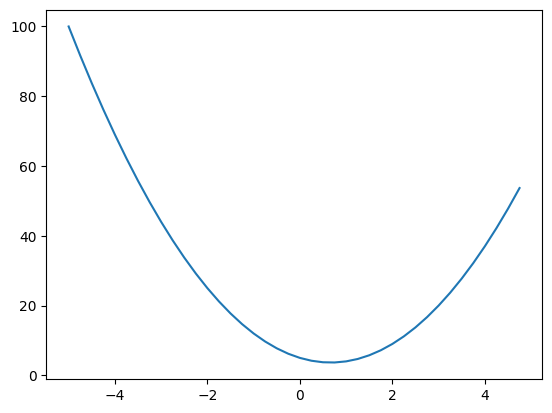

In [124]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

We can find how much the function changes with respect to a parameter by finding the difference when you add a small value and normalise by that value.

In [125]:
h = 0.0000000001
x = -3
(f(x + h) - f(x))/h

-21.999966293151374

A more complex derivative example is listed below 

In [126]:
a = 2
b = -3
c = 10
d = a*b + c
print(d)

4


We can add a small value to a to find the derivative of the function with respect to a. Which is a multivariable calculus problem

In [127]:
h = 0.0000000001
d1 = a*b + c
a += h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d1 - d2)/h)

d1 4
d2 3.9999999997
slope 3.000000248221113


Neural networks are massive data structures that need to be built out. We can build them out by hand, adding methods such as addition, substraction and what to return when it is printing by the __repr__ expressions 

We then have to add the "connective tissue" that allows us to keep track of the operations so that they can be back propegated through later

grad variable holds the gradient of the value. By default it is 0 assuming that it does not change the result

In [128]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
    
    def __repr__(self):
        return f"value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        out = Value(self.data ** other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), "tanh")
    
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward

        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
            topo.append(v)
        build_topo(self)
    
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10, label="c")
e = a*b; e.label = "e"

d = e + c; d.label = "d"

f = Value(-2.0, label="f")
l = d*f
l.label = "L"

In [129]:
print(d._prev)
print(d._op)

{value(data=10), value(data=-6.0)}
+


We can visualise these expression graphs with the above function 

In [130]:
from graphviz import Digraph

def trace(root):
    nodes = set()
    edges = set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir":"LR"})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label="{%s|data %.4f| grad %.4f}" % (n.label ,n.data, n.grad ), shape="record")

        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot



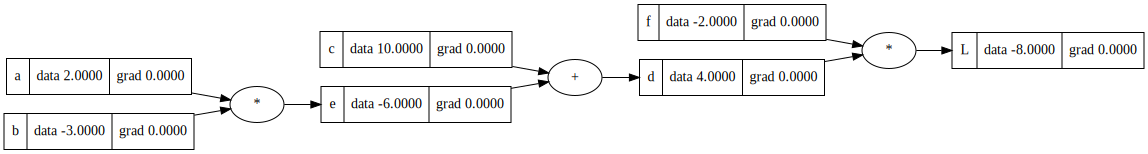

In [131]:
draw_dot(l)

we can manually backpropegate with a toy function listed below. We can apply the chain rule to see how variables such as a or b effect the result of L

In [132]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

-3.9999999999995595


We can backpropegate through a neural network that uses the Tan H activation function to add some non linearity to it. The function is plotted below 

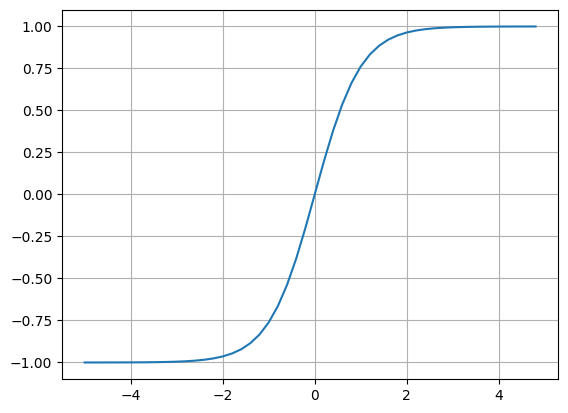

In [133]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();


A simple neural network is listed below.

In [134]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'

x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

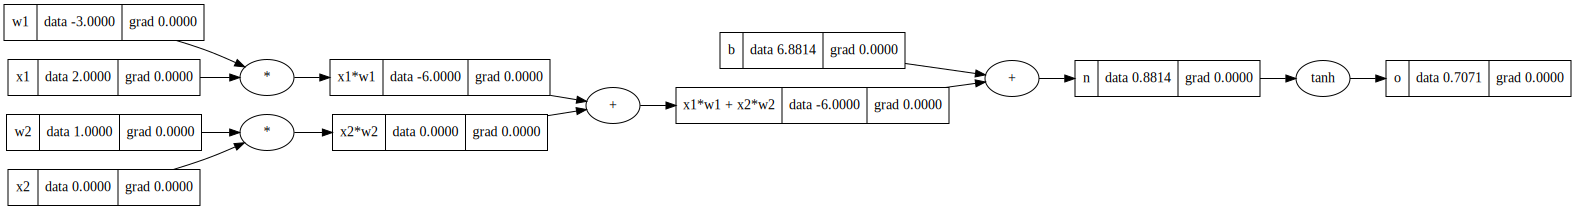

In [135]:
draw_dot(o)

We can manually work out the derivative as follows 

do/dtanh = 1-tanh^2(x) = 1- 0.7071^2 = 0.5

do/d(x2*w1 + x2*w2) = do/dtanh * dtanh/d(x1*w1 + x2*w2) = 0.5 * 1 = 0.5

do/db = do/dtanh * db = 0.5 * 1 = 0.5

do/d(x2*w2) = do/dtanh * dtanh/d(x1*w1 + x2*w2) * d(x2*w1 + x2*w2)/d(x2*w2) = 0.5 * 1 * 1 = 0.5

do/d(x1*w1) = do/dtanh * dtanh/d(x1*w1 + x2*w2) * d(x1*w1 + x2*w2)/d(x1*w1) = 0.5 * 1 * 1 = 0.5

do/w1 = do/dtanh * dtanh/d(x1*w1 + x2*w2) * d(x1*w1 + x2*w2)/d(x1*w1) * d(x1 * w1)/d(w1) = 0.5 * 1 * 1 * 2 = 1

do/w2 = do/dtanh * dtanh/d(x1*w1 + x2*w2) * d(x1*w1 + x2*w2)/d(x2*w2) * d(x2 * w2)/d(w2) = 0.5 * 1 * 1 * 0 = 0


We can manually call the backward function in the right order to calculate the gradients

In [136]:
o.grad = 1
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()


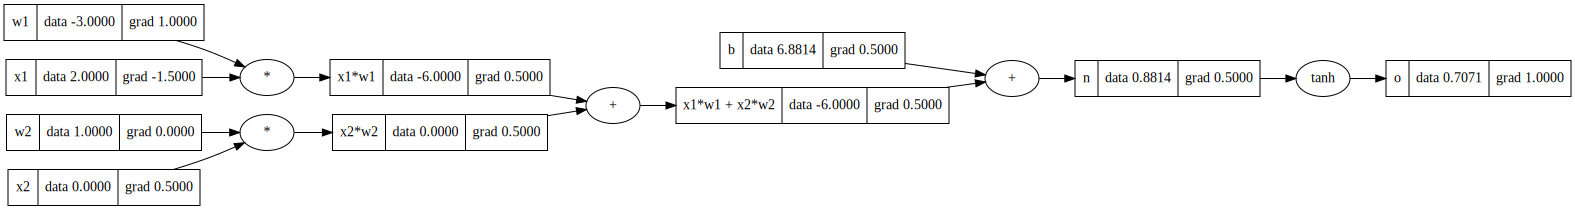

In [137]:
draw_dot(o)

To automatically execute that backprop we first must order all the nodes. We can do this by creating a topological graph via the following recursive function

In [138]:
topo_graph = []
visited = set()
def build_topo(node):
    if node not in visited:
        visited.add(node)
        for child in node._prev:
            build_topo(child)
        topo_graph.append(node)

build_topo(o)

In [139]:
topo_graph

[value(data=6.881373587019543),
 value(data=1.0),
 value(data=0.0),
 value(data=0.0),
 value(data=-3.0),
 value(data=2.0),
 value(data=-6.0),
 value(data=-6.0),
 value(data=0.8813735870195432),
 value(data=0.7071067811865476)]

We can then set the first grad to be 1 and call the backwards method in the reverse order of the topological graph 

In [140]:
o.grad = 1.0
for node in reversed(topo_graph):
    print(node.grad)
    node._backward()


1.0
0.9999999999999998
1.4999999999999996
1.9999999999999996
-7.499999999999998
4.999999999999999
1.9999999999999996
2.4999999999999996
0.0
1.4999999999999996


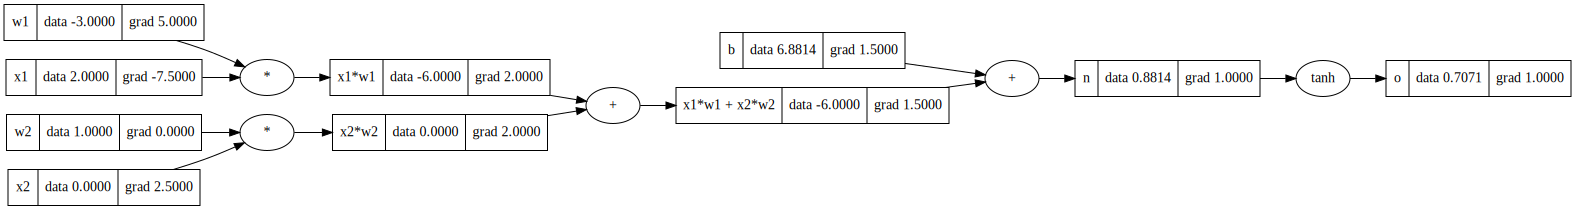

In [141]:
draw_dot(o)

We can also call the implemented backwards method

In [142]:
o.backward()

After adding methods such as exp we can break down the tanh function as follows 

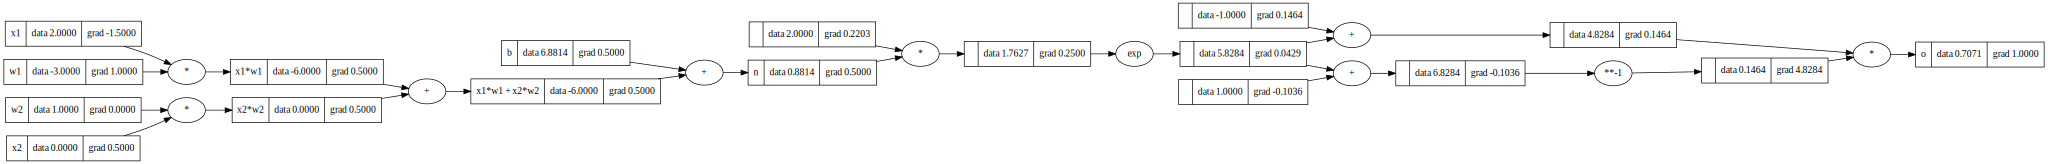

In [143]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'
o.backward()
draw_dot(o)

We can do the same things using pytorch as follows

In [144]:
import torch 

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True 
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True 

w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True 

b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data)
o.backward()
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

tensor([0.7071], dtype=torch.float64)
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


We can use the value class to create a neuron. The neuron is a list of weights that is the same dimension as the number of inputs and does a dot product of the inputs and the weights before adding a bias term to the very end

In [145]:
from typing import Any


class Neuron:
    def __init__(self, number_inputs):
        self.weights = [Value(random.uniform(-1, 1))for i in range(number_inputs)]
        self.bias = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum([weight * input for weight, input in zip(self.weights, x)])
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.weights + [self.bias]

We can also define layers as neurons that are arranged sequentially

In [146]:
from typing import Any


class Layer:
    def __init__(self, number_inputs, number_outs):
        self.neurons = [Neuron(number_inputs) for i in range(number_outs)]  

    def __call__(self, x):
        return [neuron(x)for neuron in self.neurons]
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

finally we can create an mlp as being a list of layers that execute sequentially

In [147]:
class MLP:
    def __init__(self, number_of_ins, outs):
        layer_shape_list = [number_of_ins] + outs
        self.layers = [Layer(layer_shape_list[i], layer_shape_list[i + 1]) for i in range(len(outs))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


We can turn this into a neural network and use a loss function in order to quantify the performance of the network in order to optimise later on 

In [148]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

mlp = MLP(3, [4, 4, 1])
y_preds = [mlp(x) for x in xs]
y_preds

[[value(data=-0.83037645801372)],
 [value(data=-0.6717990232929745)],
 [value(data=0.22601511796796203)],
 [value(data=-0.8039838197653254)]]

In [149]:
loss = sum((yout[0] - ygt)**2 for ygt, yout in zip(ys, y_preds))
print(loss)

value(data=8.215464550623388)


In [150]:
loss.backward()

In [151]:
mlp.layers[0].neurons[0].weights[0].grad

-1.3659209805393373

Adding a paramteters function allows us to get all the parameters in the network

In [152]:
len(mlp.parameters())

41

We can use a training loop to fit the neural network on the data and then optimise. NOTE YOU MUST 0 THE GRADIENTS 

In [183]:
for k in range(200):
  
  # forward pass
  ypred = [mlp(x) for x in xs]
  loss = sum((yout[0] - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in mlp.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in mlp.parameters():
    p.data += -0.0005 * p.grad
  
  print(k, loss.data)

0 0.0005673802251337466
1 0.000567375626739682
2 0.0005673710242250646
3 0.0005673664349743047
4 0.0005673619344803172
5 0.000567357311171716
6 0.0005673527450947029
7 0.000567348220863327
8 0.0005673436229033685
9 0.0005673390417666161
10 0.0005673343721402259
11 0.0005673298447627035
12 0.0005673252745981945
13 0.0005673207038240364
14 0.0005673162134126866
15 0.0005673115881193348
16 0.0005673069866152315
17 0.0005673024654705657
18 0.0005672978341797444
19 0.0005672932046602181
20 0.0005672886259037618
21 0.000567284077389251
22 0.0005672795081295589
23 0.0005672749166497398
24 0.0005672703182239467
25 0.0005672656963683039
26 0.0005672612238386942
27 0.0005672566871093109
28 0.0005672521034200521
29 0.000567247593290035
30 0.0005672430018079386
31 0.0005672383869846394
32 0.0005672338442456306
33 0.0005672292430337321
34 0.0005672246559251042
35 0.0005672200623222357
36 0.0005672154926904078
37 0.0005672109053283118
38 0.0005672063185941962
39 0.0005672017294356027
40 0.0005671971

In [184]:
ypred

[[value(data=0.9883999702105949)],
 [value(data=-0.9893320710673262)],
 [value(data=-0.9873574815478352)],
 [value(data=0.9874194088853726)]]